# **Hack&Roll 2021 i-Doc (Solo Leveling)**

Vision Impairment can be a serious implication on one’s health. According to the key facts stated by the World Health Organization “Globally, at least 2.2 billion people have a vision impairment or blindness, of whom at least 1 billion have a vision impairment that could have been prevented or has yet to be addressed.” Do you have the ability to better detect potential vision issues and help change thousands, if not, millions of lives? 

For example, the given dataset looks at cataract and normal eye image dataset for cataract detection. Participants are encouraged to use other available datasets to better analyse and share their findings regarding the detection of the potential risk of visual problems detection, preferably relating to the Asia region. Indeed this problem statement covers a wide area of visual impairments and does not need to focus solely on cataract. Participants are free to explore other options of eye disease detection.  

* Present Insight into the data by mean of visualization and/or interactive means
* Prediction model for eye disease 

For reference:
https://www.kaggle.com/jr2ngb/cataractdataset?Vision 

In [1]:
import os
import numpy as np
import shutil
import matplotlib                  # 2D Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns              # Python Data Visualization Library based on matplotlib
from sklearn.metrics import classification_report
#import geopandas as gpd            # Python Geospatial Data Library
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Importing all necessary libraries 
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from keras.models import Model, Sequential 
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K
from keras.optimizers import SGD

from keras.applications import ResNet50

In [3]:
#Creating Train / Val / Test folders 
root_dir = 'cataract_dataset_bundle_archive'
normal = '/1_normal'
cataract = '/2_cataract'
glaucoma = '/2_glaucoma'
retina_disease = '/3_retina_disease'

Here the data is pre-processed to divide it into train, validation and test files. I decided to go ahead with a 70:15:15 split.

In [4]:
img_width, img_height = 224, 224

In [5]:
#Creating Train / Val / Test folders 
root_dir = 'cataract_dataset_bundle_archive'
classes = ['/1_normal', '/2_cataract', '/2_glaucoma', '/3_retina_disease']

for class_type in classes:
    os.makedirs(root_dir + '/train' + class_type)
    os.makedirs(root_dir + '/val' + class_type)
    os.makedirs(root_dir + '/test' + class_type)

    src = root_dir + class_type

    allFiles = os.listdir(src)
    np.random.shuffle(allFiles)
    train_Files, val_Files, test_Files = np.split(np.array(allFiles),
                                                          [int(len(allFiles)*0.7), int(len(allFiles)*0.85)])
                                                          
    train_Files = [src+'/'+ name for name in train_Files.tolist()]
    val_Files = [src+'/' + name for name in val_Files.tolist()]
    test_Files = [src+'/' + name for name in test_Files.tolist()]

    print('Class: ', class_type)
    print('Total images: ', len(allFiles))
    print('Training: ', len(train_Files))
    print('Validation: ', len(val_Files))
    print('Testing: ', len(test_Files))

    for name in train_Files:
        shutil.copy(name, root_dir + "/train" + class_type)
    
    for name in val_Files:
        shutil.copy(name, root_dir + "/val" + class_type)
    
    for name in test_Files:
        shutil.copy(name, root_dir + "/test" + class_type)

FileExistsError: [Errno 17] File exists: 'cataract_dataset_bundle_archive/train/1_normal'

### Pre-processed data is stored in a new directory - "Data"

In [6]:
train_data_dir = f'data/train'
validation_data_dir = f'data/val'
nb_train_samples = 420 
nb_validation_samples = 90
epochs = 10
batch_size = 32

Now data augmentation is done to make the batch-sizes equal and increase our dataset to improve the accuracy of our model. This would help to train the neural network better without actually collecting or trying to find new data.

In [7]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

Found 420 images belonging to 4 classes.
Found 90 images belonging to 4 classes.


Decide to use ResNet as the base model and ADAM as the optimizer since after running a few tests I realised that ADAM was giving the best results for our dataset. I even tried to configure the epochs, batch sizes, density of the images and other parameters, to see which combination of parameters gives us the best results. The finally implemented model, is what gave overall best results.

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False)

In [9]:
base_model.summary()

n[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, None, None, 5 0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, None, None, 2 131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, None, None, 2 0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, None, None, 2 590080      conv4_block1_1_relu[0][0] 

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
%%time
    history = model.fit_generator(train_generator, train_generator.n // batch_size, epochs=5, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
13/13 [==============================] - 85s 7s/step - loss: 1.3932 - accuracy: 0.4665 - val_loss: 0.9879 - val_accuracy: 0.7031
Epoch 2/5
13/13 [==============================] - 67s 5s/step - loss: 1.2731 - accuracy: 0.5077 - val_loss: 0.9703 - val_accuracy: 0.7031
Epoch 3/5
13/13 [==============================] - 70s 5s/step - loss: 1.2870 - accuracy: 0.4948 - val_loss: 0.9702 - val_accuracy: 0.7031
Epoch 4/5
13/13 [==============================] - 67s 5s/step - loss: 1.2839 - accuracy: 0.4871 - val_loss: 1.0703 - val_accuracy: 0.7031
Epoch 5/5
13/13 [==============================] - 66s 5s/step - loss: 1.2673 - accuracy: 0.5000 - val_loss: 0.9664 - val_accuracy: 0.7031
CPU times: user 17min 25s, sys: 1min 37s, total: 19min 3s
Wall time: 7min 17s


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


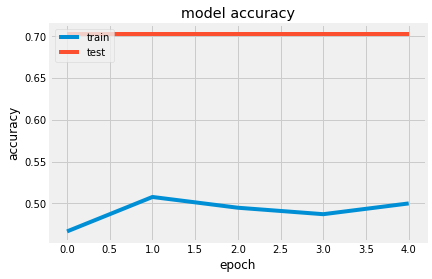

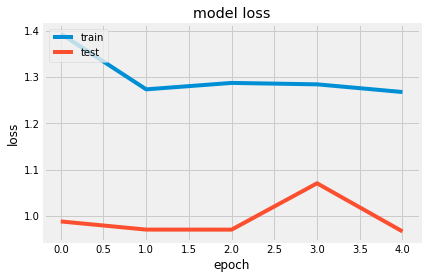

In [15]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


After seeing the low results of multi-class classification, I decided to go ahead and do binary classification to check if there is some problem with our model and can it be improved or is there any issue with our dataset. Therefore, I built binary classifiers for the each of the diseases. The classifiers were trained to identify only one disease at a time.

In [16]:
test_data_dir = f'data/binary_classifiers/cataract/test'

testing_generator = test_datagen.flow_from_directory(test_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

# test model
print("-------------------------------  TESTING BINARY CLASSIFICATION MODEL FOR CATARACT  ----------------------------------------")
testing_generator.reset()
prediction_index = model.predict_generator(testing_generator, steps=(60 // batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
prediction_index = np.argmax(prediction_index, axis=1)

# show a nicely formatted classification report
print(classification_report(testing_generator.classes, prediction_index, target_names=testing_generator.class_indices.keys()))

Found 60 images belonging to 2 classes.
-------------------------------  TESTING BINARY CLASSIFICATION MODEL FOR CATARACT  ----------------------------------------
Instructions for updating:
Please use Model.predict, which supports generators.
              precision    recall  f1-score   support

    1_normal       0.75      1.00      0.86        45
  2_cataract       0.00      0.00      0.00        15

    accuracy                           0.75        60
   macro avg       0.38      0.50      0.43        60
weighted avg       0.56      0.75      0.64        60



In [17]:
train_data_dir = f'data/binary_classifiers/glaucoma/train'
validation_data_dir = f'data/binary_classifiers/glaucoma/val'
nb_train_samples = 280
nb_validation_samples = 60
epochs = 10
batch_size = 8
train_datagen = ImageDataGenerator(rescale=1. / 255,
shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)   

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 280 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [18]:
%%time
    history = model.fit_generator(train_generator, train_generator.n // batch_size, epochs=5, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/5
35/35 [==============================] - 62s 2s/step - loss: 0.6701 - accuracy: 0.7179 - val_loss: 0.5073 - val_accuracy: 0.8036
Epoch 2/5
35/35 [==============================] - 57s 2s/step - loss: 0.5721 - accuracy: 0.7500 - val_loss: 0.5258 - val_accuracy: 0.8036
Epoch 3/5
35/35 [==============================] - 56s 2s/step - loss: 0.5675 - accuracy: 0.7500 - val_loss: 0.5013 - val_accuracy: 0.8036
Epoch 4/5
35/35 [==============================] - 64s 2s/step - loss: 0.6509 - accuracy: 0.6964 - val_loss: 0.5051 - val_accuracy: 0.8036
Epoch 5/5
35/35 [==============================] - 67s 2s/step - loss: 0.5858 - accuracy: 0.7500 - val_loss: 0.4982 - val_accuracy: 0.8036
CPU times: user 13min 47s, sys: 1min 18s, total: 15min 5s
Wall time: 5min 26s


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


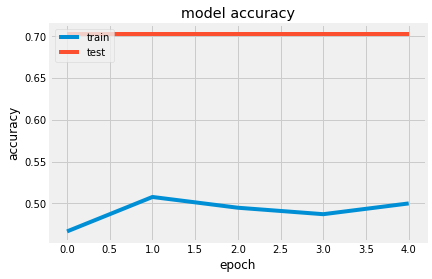

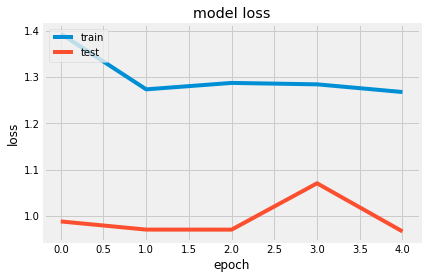

In [13]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [19]:
test_data_dir = f'data/binary_classifiers/glaucoma/test'

testing_generator = test_datagen.flow_from_directory(test_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

# test model
print("-------------------------------  TESTING BINARY CLASSIFICATION MODEL FOR GLAUCOMA  ----------------------------------------")
testing_generator.reset()
prediction_index = model.predict_generator(testing_generator, steps=(60 // batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
prediction_index = np.argmax(prediction_index, axis=1)

# show a nicely formatted classification report
print(classification_report(testing_generator.classes, prediction_index, target_names=testing_generator.class_indices.keys()))

Found 61 images belonging to 2 classes.
-------------------------------  TESTING BINARY CLASSIFICATION MODEL FOR GLAUCOMA  ----------------------------------------
              precision    recall  f1-score   support

    1_normal       0.74      1.00      0.85        45
  2_glaucoma       0.00      0.00      0.00        16

    accuracy                           0.74        61
   macro avg       0.37      0.50      0.42        61
weighted avg       0.54      0.74      0.63        61



In [20]:
train_data_dir = f'data/binary_classifiers/retina_disease/train'
validation_data_dir = f'data/binary_classifiers/retina_disease/val'
nb_train_samples = 280
nb_validation_samples = 60
epochs = 10
batch_size = 8
train_datagen = ImageDataGenerator(rescale=1. / 255,
shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)   

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 280 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [21]:
%%time
    history = model.fit_generator(train_generator, train_generator.n // batch_size, epochs=5, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/5
35/35 [==============================] - 60s 2s/step - loss: 0.6035 - accuracy: 0.7214 - val_loss: 0.6437 - val_accuracy: 0.8036
Epoch 2/5
35/35 [==============================] - 53s 2s/step - loss: 0.5959 - accuracy: 0.7500 - val_loss: 0.5277 - val_accuracy: 0.8036
Epoch 3/5
35/35 [==============================] - 53s 2s/step - loss: 0.5729 - accuracy: 0.7500 - val_loss: 0.4995 - val_accuracy: 0.8036
Epoch 4/5
35/35 [==============================] - 53s 2s/step - loss: 0.5821 - accuracy: 0.7500 - val_loss: 0.5031 - val_accuracy: 0.8036
Epoch 5/5
35/35 [==============================] - 54s 2s/step - loss: 0.5789 - accuracy: 0.7500 - val_loss: 0.5326 - val_accuracy: 0.8036
CPU times: user 13min 47s, sys: 1min 15s, total: 15min 3s
Wall time: 4min 56s


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


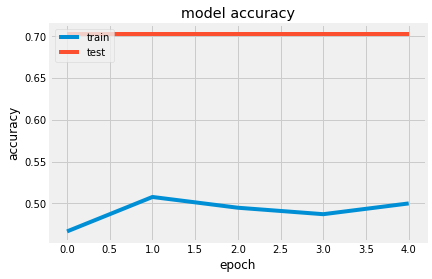

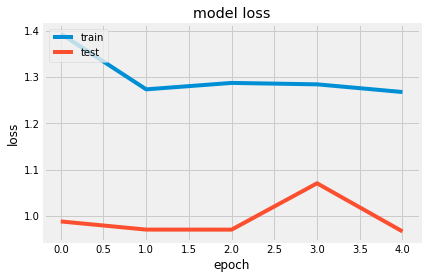

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


In [22]:
test_data_dir = f'data/binary_classifiers/retina_disease/test'

testing_generator = test_datagen.flow_from_directory(test_data_dir,
    shuffle=False,
    target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical')

# test model
print("-------------------------------  TESTING BINARY CLASSIFICATION MODEL FOR RETINA DISEASES  ----------------------------------------")
testing_generator.reset()
prediction_index = model.predict_generator(testing_generator, steps=(60 // batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
prediction_index = np.argmax(prediction_index, axis=1)

# show a nicely formatted classification report
print(classification_report(testing_generator.classes, prediction_index, target_names=testing_generator.class_indices.keys()))

Found 60 images belonging to 2 classes.
-------------------------------  TESTING BINARY CLASSIFICATION MODEL FOR RETINA DISEASES  ----------------------------------------
                  precision    recall  f1-score   support

        1_normal       0.75      1.00      0.86        45
3_retina_disease       0.00      0.00      0.00        15

        accuracy                           0.75        60
       macro avg       0.38      0.50      0.43        60
    weighted avg       0.56      0.75      0.64        60



Since this time our model gives an approximately 80% accuracy, it leads to the conclusion that there might be issue with the dataset - I can use it to develop binary classifiers; but I cannot use it for developing multiclass classifiers. This is possibly because of the small size of the dataset. Another possible reason could be that the dataset has biased samples.